In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import lmpsetup
import hmdsetup

import lmp
import hmd

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import analysis

import scipy.constants as cnt

import shutil
import os
import mdtraj as md
import statsmodels.tsa.stattools
import MDAnalysis.analysis as mda
import scipy
from matplotlib.lines import Line2D
import itertools


from style_vars import *
plt.style.use('default')
plt.style.use('style.mplstyle')

hps_lines = [Line2D([0], [0], color='black', ls='--'),
                Line2D([0], [0], color='black')]

wt_d4_lines = [Line2D([0], [0], color=C_W),
                Line2D([0], [0], color=C_4)]

In [2]:
wt_08_hps_T = lmp.LMP(md_dir='/home/adria/data/real_final/HPS-T/0.8/WT', every=100)

d4_08_hps_T = lmp.LMP(md_dir='/home/adria/data/real_final/HPS-T/0.8/D4', every=100)

> Run Completed at 100.00% for CPEB4_alpha. Ran 1000000000 steps for a total of 100001 frames 
> Taking frames every 100 for a total of [1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001] to avoid strong correlations
> Run Completed at 100.00% for CPEB4_D4. Ran 1000000000 steps for a total of 100001 frames 
> Taking frames every 100 for a total of [1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001] to avoid strong correlations


In [3]:
wt_sc_ijs, wt_sc_d_ijs, wt_sc_err = wt_08_hps_T.ij_from_contacts()
wt_florys = wt_08_hps_T.flory_scaling_fit(ijs=[wt_sc_ijs,wt_sc_d_ijs,wt_sc_err])[0]

d4_sc_ijs, d4_sc_d_ijs, d4_sc_err = d4_08_hps_T.ij_from_contacts()
d4_florys = d4_08_hps_T.flory_scaling_fit(ijs=[d4_sc_ijs,d4_sc_d_ijs,d4_sc_err])[0]

In [4]:
wt_florys_eq = wt_08_hps_T.flory_scaling_formula()
d4_florys_eq = d4_08_hps_T.flory_scaling_formula()

def get_tc(florys, temps):
    slope = florys[1]-florys[0]
    slope /= temps[1]-temps[0]
    x = np.linspace(270,300)
    fit = slope*(x-temps[1])+florys[1]
    return (0.5-florys[1])/slope+temps[1]

wt_tc_fit = get_tc(wt_florys, wt_08_hps_T.temperatures)
d4_tc_fit = get_tc(d4_florys, d4_08_hps_T.temperatures)
wt_tc_eq = get_tc(wt_florys_eq, wt_08_hps_T.temperatures)
d4_tc_eq = get_tc(d4_florys_eq, wt_08_hps_T.temperatures)

In [5]:
wt_slab = np.genfromtxt('/home/adria/data/real_final/08_pd_wt.txt')
rho_d = wt_slab[:7,1]
rho_c = wt_slab[7:,1]
print(wt_slab[7:,0])
fit, cr = wt_08_hps_T.find_Tc_from_diagram(rho_c=rho_c,rho_d=rho_d,temperatures=(wt_slab[7:,0]))
rho_c, tc = cr[0], cr[1]
rho_c, tc

[277. 284. 291. 298. 305. 312. 320.]
PPT1 [150.6183348  272.24476529] PPT2 [-136.75153307  210.37034719    3.71082701]


/home/adria/scripts/md/md/analysis.py:1233: RuntimeWarning: invalid value encountered in power
  return A * (x - Tc_sc) ** beta


(150.61833479784968, 272.2447652920875)

/home/adria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


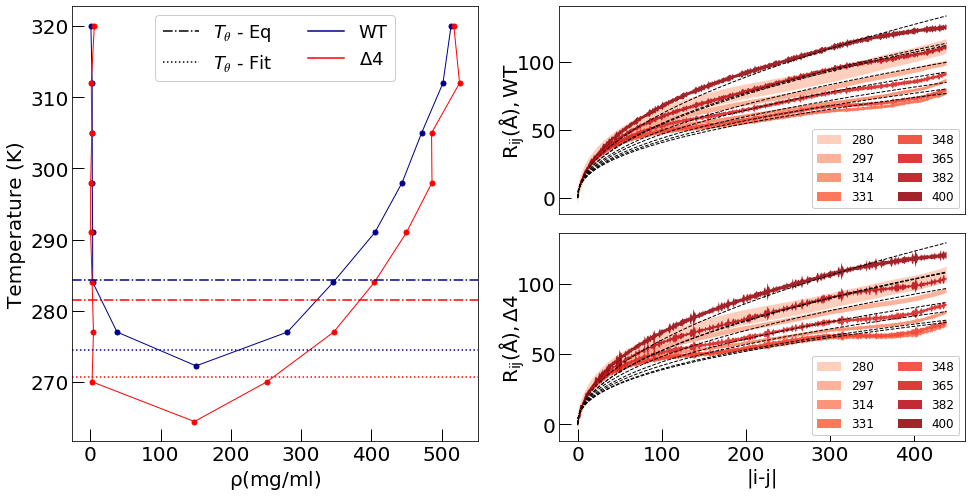

In [18]:
fig = plt.figure(figsize=(16, 8))

grid = plt.GridSpec(16, 8, wspace=2, hspace=2)
ax1 = plt.subplot(grid[0:16, 0:4])
ax2 = plt.subplot(grid[0:8, 4:8])
ax3 = plt.subplot(grid[8:16, 4:8])
ax2.set_xticks([])

wt_slab = np.genfromtxt('/home/adria/data/real_final/08_pd_wt.txt')
d4_slab = np.genfromtxt('/home/adria/data/real_final/08_pd_d4.txt')

cmap = plt.get_cmap('Reds')
rhoss = np.append(np.append(wt_slab[7:,1][::-1],rho_c), wt_slab[:7,1])
tempss = np.append(np.append(wt_slab[7:,0][::-1],tc), wt_slab[:7,0][::-1])
ax1.plot(rhoss, tempss, marker='o', ls='-', color=C_W, markersize=5, lw=1)
ax1.plot(d4_slab[:,0], d4_slab[:,1], color=C_4, ls='-', marker='o', lw=1, markersize=5)
    
for t in range(len(wt_08_hps_T.temperatures)):
    ijs = wt_sc_ijs
    dijs = wt_sc_d_ijs
    err = wt_sc_err
    florys = wt_florys

    
#     ax2.plot(ijs, dijs[t,:], label=wt_08_hps_T.temperatures[t], color=cmap((t+2)/10))
    ax2.fill_between(ijs, dijs[t,:]-err[t,:], dijs[t,:]+err[t,:], facecolor=cmap((t+2)/10),alpha=0.9, label=f"{wt_08_hps_T.temperatures[t]:.0f}")
    ax2.plot(ijs, 5.5*ijs**florys[t], color='black',  alpha=1, ls='--', lw=1)
    ax2.legend(fontsize=12, ncol=2, loc='lower right')
    
    ijs = d4_sc_ijs
    dijs = d4_sc_d_ijs
    err = d4_sc_err
    florys = d4_florys
    
#     ax3.plot(ijs, dijs[t,:], label=wt_08_hps_T.temperatures[t], color=cmap((t+2)/10))
    ax3.fill_between(ijs, dijs[t,:]-err[t,:], dijs[t,:]+err[t,:], facecolor=cmap((t+2)/10),alpha=0.9, label=f"{wt_08_hps_T.temperatures[t]:.0f}")
    ax3.plot(ijs, 5.5*ijs**florys[t], color='black',  alpha=1, ls='--', lw=1)
    ax3.legend(fontsize=12, ncol=2, loc='lower right')
    

# ax1.legend([Line2D([0], [0], color=C_W, ls='dashdot'), Line2D([0], [0], color=C_4, ls='dashdot')
#            , Line2D([0], [0], color=C_W, ls='dotted'), Line2D([0], [0], color=C_4, ls='dotted')],
#            ["$T_{𝜃,WT}$ - Eq","$T_{𝜃,\Delta 4}$ - Eq","$T_{𝜃,WT}$ - Fit","$T_{𝜃,\Delta 4}$ - Fit"], ncol=2, fontsize=16, loc='upper center')


ax1.legend([Line2D([0], [0], color='black', ls='dashdot'), Line2D([0], [0], color='black', ls='dotted'),
            Line2D([0], [0], color=C_W), Line2D([0], [0], color=C_4)],
           ["$T_{𝜃}$ - Eq","$T_{𝜃}$ - Fit","WT", "$\Delta$4"], ncol=2, loc='upper center')

ax1.axhline(wt_tc_fit, color=C_W, ls='dotted')
ax1.axhline(d4_tc_fit, color=C_4, ls='dotted')
ax1.axhline(wt_tc_eq, color=C_W, ls='dashdot')
ax1.axhline(d4_tc_eq, color=C_4, ls='dashdot')
ax1.set_xlabel("$\mathrm{ρ(mg/ml)}$")
ax1.set_ylabel("Temperature (K)")
ax3.set_xlabel("|i-j|")
ax2.set_ylabel("$\mathrm{R_{ij} (\AA), WT}$", labelpad=-10)
ax3.set_ylabel("$\mathrm{R_{ij} (\AA), \Delta 4}$", labelpad=-10)

fig.tight_layout()

In [2]:
wt_1_hps_T = lmp.LMP(md_dir='/home/adria/data/real_final/HPS-T/1.0/WT')
wt_1_hps = lmp.LMP(md_dir='/home/adria/data/real_final/HPS/1.0/WT')

> Run Completed at 100.00% for CPEB4_alpha. Ran 1000000000 steps for a total of 100001 frames 
> Taking frames every None for a total of [99701, 99701, 99701, 99701, 99701, 99701, 99701, 99701] to avoid strong correlations
> Run Completed at 100.00% for CPEB4_alpha. Ran 1000000000 steps for a total of 100001 frames 
> Taking frames every None for a total of [99701, 99701, 99701, 99701, 99701, 99701, 99701, 99701] to avoid strong correlations


In [2]:
wt_08_hps_T = lmp.LMP(md_dir='/home/adria/data/real_final/HPS-T/0.8/WT')
# wt_08_hps = lmp.LMP(md_dir='/home/adria/data/real_final/HPS/0.8/WT')

> Run Completed at 100.00% for CPEB4_alpha. Ran 1000000000 steps for a total of 100001 frames 
> Taking frames every 10 for a total of [10001, 10001, 10001, 10001, 10001, 10001, 10001, 10001] to avoid strong correlations


In [3]:
tr = wt_08_hps_T

for i in range(len(tr.structures)):
    tr.structures[i] = tr.structures[i][::10]

In [4]:
t_ijs, t_d_ijs, t_err = tr.ij_from_contacts()

In [5]:
t_florys = tr.flory_scaling_fit(ijs=[t_ijs,t_d_ijs,t_err])[0]

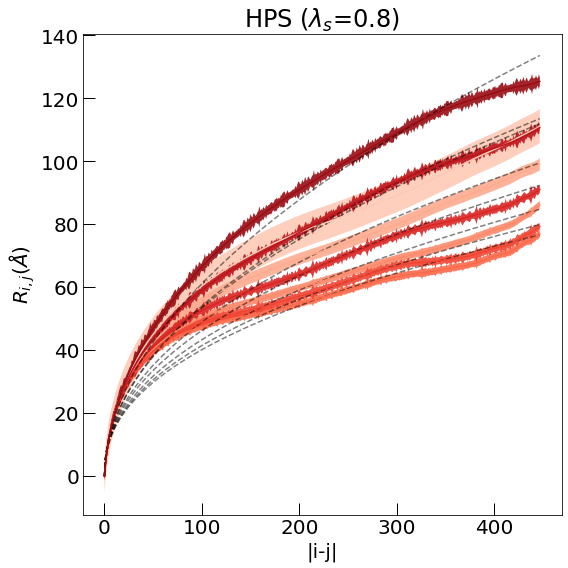

In [10]:
fig, axs = plt.subplots(figsize=(8,8))

cmap = plt.get_cmap('Reds')
for t in range(len(tr.temperatures)):
    axs.plot(t_ijs, 5.5*t_ijs**t_florys[t], color='black', alpha=0.5, ls='--')
    axs.plot(t_ijs, t_d_ijs[t,:], label=tr.temperatures[t], color=cmap((t+2)/10))
    axs.fill_between(t_ijs, t_d_ijs[t,:]-t_err[t,:], t_d_ijs[t,:]+t_err[t,:], facecolor=cmap((t+2)/10),alpha=0.9)

axs.set_xlabel("|i-j|")
axs.set_ylabel("$R_{i,j} (\AA)$")
axs.set_title('HPS ($\lambda_s$=0.8)')

fig.tight_layout()

In [2]:
wt_1_hps_T = lmp.LMP(md_dir='/home/adria/data/real_final/HPS-T/1.0/WT', every=100)
t_ijs, t_d_ijs, t_err = wt_1_hps_T.ij_from_contacts()
wt_1_hps = lmp.LMP(md_dir='/home/adria/data/real_final/HPS/1.0/WT', every=100)
ijs, d_ijs, err = wt_1_hps.ij_from_contacts()

> Run Completed at 100.00% for CPEB4_alpha. Ran 1000000000 steps for a total of 100001 frames 
> Taking frames every 100 for a total of [1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001] to avoid strong correlations
> Run Completed at 100.00% for CPEB4_alpha. Ran 1000000000 steps for a total of 100001 frames 
> Taking frames every 100 for a total of [1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001] to avoid strong correlations


In [14]:
t_florys = wt_1_hps_T.flory_scaling_fit(ijs=[t_ijs,t_d_ijs,t_err])[0]
florys = wt_1_hps.flory_scaling_fit(ijs=[ijs,d_ijs,err])[0]

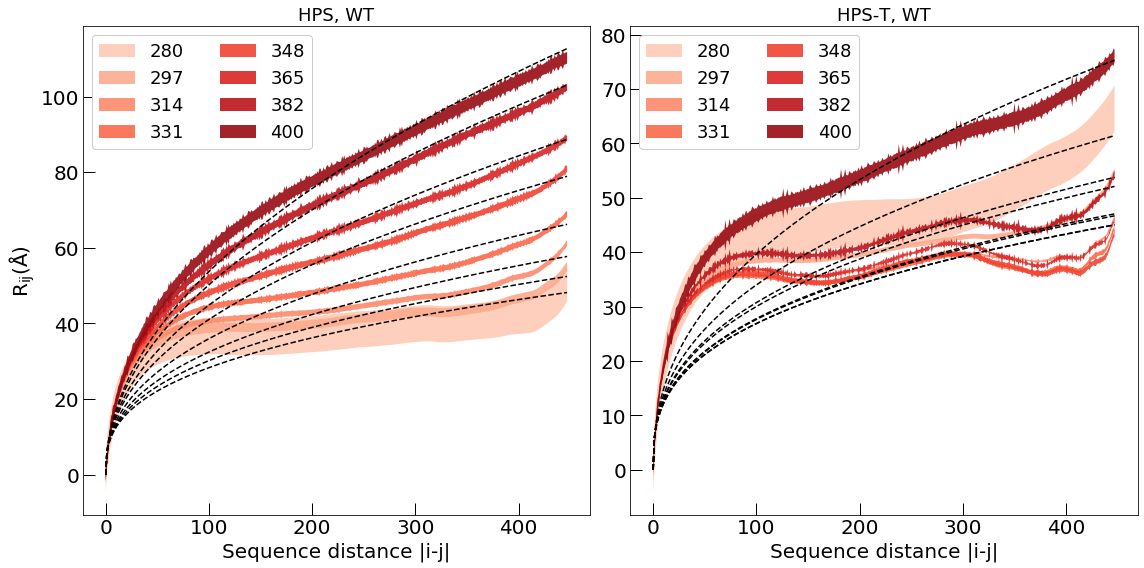

In [62]:
fig, axs = plt.subplots(1,2, figsize=(16,8))

cmap = plt.get_cmap('Reds')
for t in range(len(wt_1_hps.temperatures)):
    axs[0].fill_between(ijs, d_ijs[t,:]-err[t,:], d_ijs[t,:]+err[t,:], facecolor=cmap((t+2)/10),alpha=0.9, label=f"{wt_1_hps.temperatures[t]:.0f}")
#     axs[0].plot(ijs, d_ijs[t,:], , color=cmap((t+2)/10))
    axs[0].plot(ijs, 5.5*ijs**florys[t], color='black', alpha=1, ls='--', lw=1.5)

axs[0].set_xlabel("Sequence distance |i-j|")
axs[0].set_ylabel("$\mathrm{R_{ij} (\AA)}$")
axs[0].set_title('HPS, WT', fontsize=18)
axs[0].legend(ncol=2, loc='upper left')

cmap = plt.get_cmap('Reds')
for t in range(len(wt_1_hps_T.temperatures)):
#     axs[1].plot(t_ijs, 5.5*t_ijs**t_florys[t], color='black', alpha=0.6, ls='--', lw=2)
#     axs[1].plot(t_ijs, t_d_ijs[t,:], label=wt_1_hps_T.temperatures[t], color=cmap((t+2)/10))
    axs[1].fill_between(t_ijs, t_d_ijs[t,:]-t_err[t,:], t_d_ijs[t,:]+t_err[t,:], facecolor=cmap((t+2)/10),alpha=0.9, label=f"{wt_1_hps.temperatures[t]:.0f}")
    axs[1].plot(t_ijs, 5.5*t_ijs**t_florys[t], color='black', alpha=1, ls='--', lw=1.5)


axs[1].set_xlabel("Sequence distance |i-j|")
axs[1].set_title('HPS-T, WT', fontsize=18)
axs[1].legend(ncol=2, loc='upper left')

plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(16,16))

cmap = plt.get_cmap('Reds')
for t in range(len(wt_1_hps.temperatures)):
    axs[0][0].plot(ijs, 5.5*ijs**florys[t], color='black', alpha=0.5, ls='--')
    axs[0][0].plot(ijs, d_ijs[t,:], label=wt_1_hps.temperatures[t], color=cmap((t+2)/10))
    axs[0][0].fill_between(ijs, d_ijs[t,:]-err[t,:], d_ijs[t,:]+err[t,:], facecolor=cmap((t+2)/10),alpha=0.9)
    axs[1][0].plot(wt_1_hps.temperatures[t], florys[t], color=cmap((t+2)/10), marker='o', markersize=8)

axs[1][0].set_xlabel("Temperature (K)")
axs[1][0].set_ylabel("ν")

axs[0][0].set_xlabel("|i-j|")
axs[0][0].set_ylabel("$R_{i,j}$")
axs[0][0].set_title('HPS')

cmap = plt.get_cmap('Reds')
for t in range(len(wt_1_hps_T.temperatures)):
    axs[0][1].plot(t_ijs, 5.5*t_ijs**t_florys[t], color='black', alpha=0.5, ls='--')
    axs[0][1].plot(t_ijs, t_d_ijs[t,:], label=wt_1_hps.temperatures[t], color=cmap((t+2)/10))
    axs[0][1].fill_between(t_ijs, t_d_ijs[t,:]-t_err[t,:], t_d_ijs[t,:]+t_err[t,:], facecolor=cmap((t+2)/10),alpha=0.9)
    axs[1][1].plot(wt_1_hps_T.temperatures[t], t_florys[t], color=cmap((t+2)/10), marker='o', markersize=8)
axs[1][1].set_xlabel("Temperature (K)")

axs[0][1].set_xlabel("|i-j|")
axs[0][1].set_title('HPS-T')

